# Upscaling using Renormalization

This notebook presents how to use renromalization to upscale a 3D field of hydraulic conductivity
Three methods are used:
- Simplified renormalization
- Standard renormalization
- Tensorial renormalization

In [1]:
import uppy
from uppy import upscale_k
import numpy as np
import matplotlib.pyplot as plt 
import pyvista as pv
import geone


In [2]:
pv.set_jupyter_backend("static")

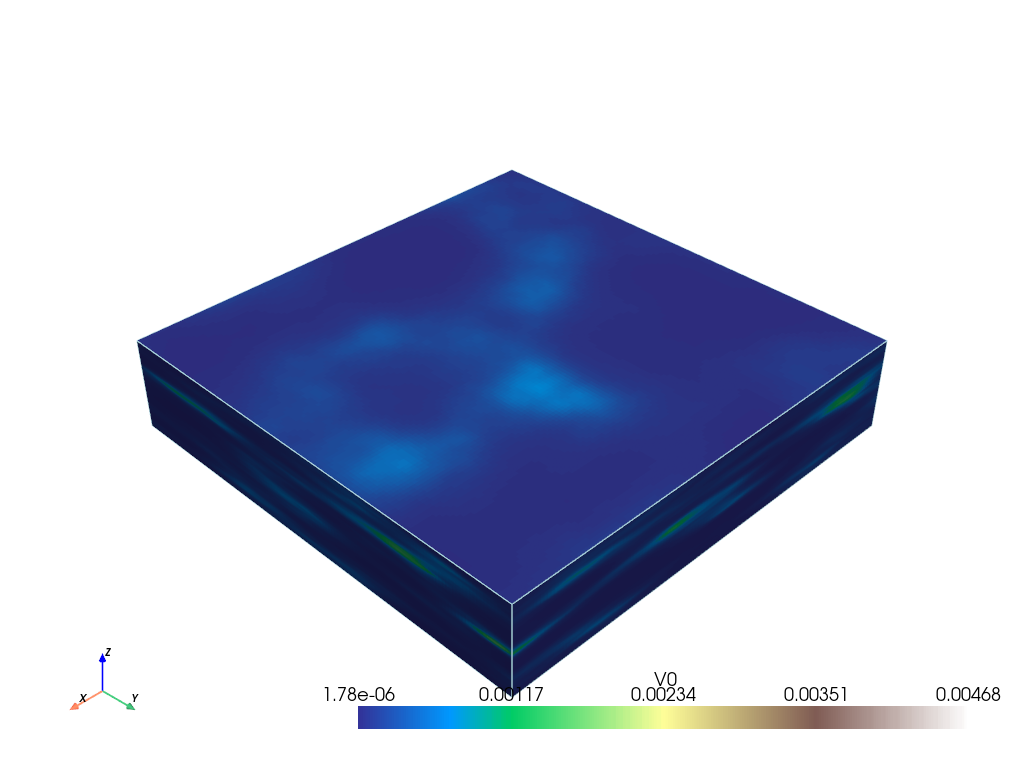

In [3]:
# generate a random field
np.random.seed(3)
cm = geone.covModel.CovModel3D(elem=[("cubic", {"w":.2, "r":[100, 100, 10]})])
sim = geone.multiGaussian.multiGaussianRun(cm, (128, 128, 128), (2, 2, .4), [0, 0, 0], mean=-4)
sim.val = 10**sim.val
geone.imgplot3d.drawImage3D_surface(sim, cmap="terrain")

In [4]:
factor_x = 8
factor_y = 8
factor_z = 8
dx = 2
dy = 2
dz = .4

## Standard renormalization

### Direct scheme

In [5]:
field_kxx, field_kyy, field_kzz = upscale_k(sim.val[0], method="standard_renormalization", dx=2, dy=2, dz=.4, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z, scheme="direct")

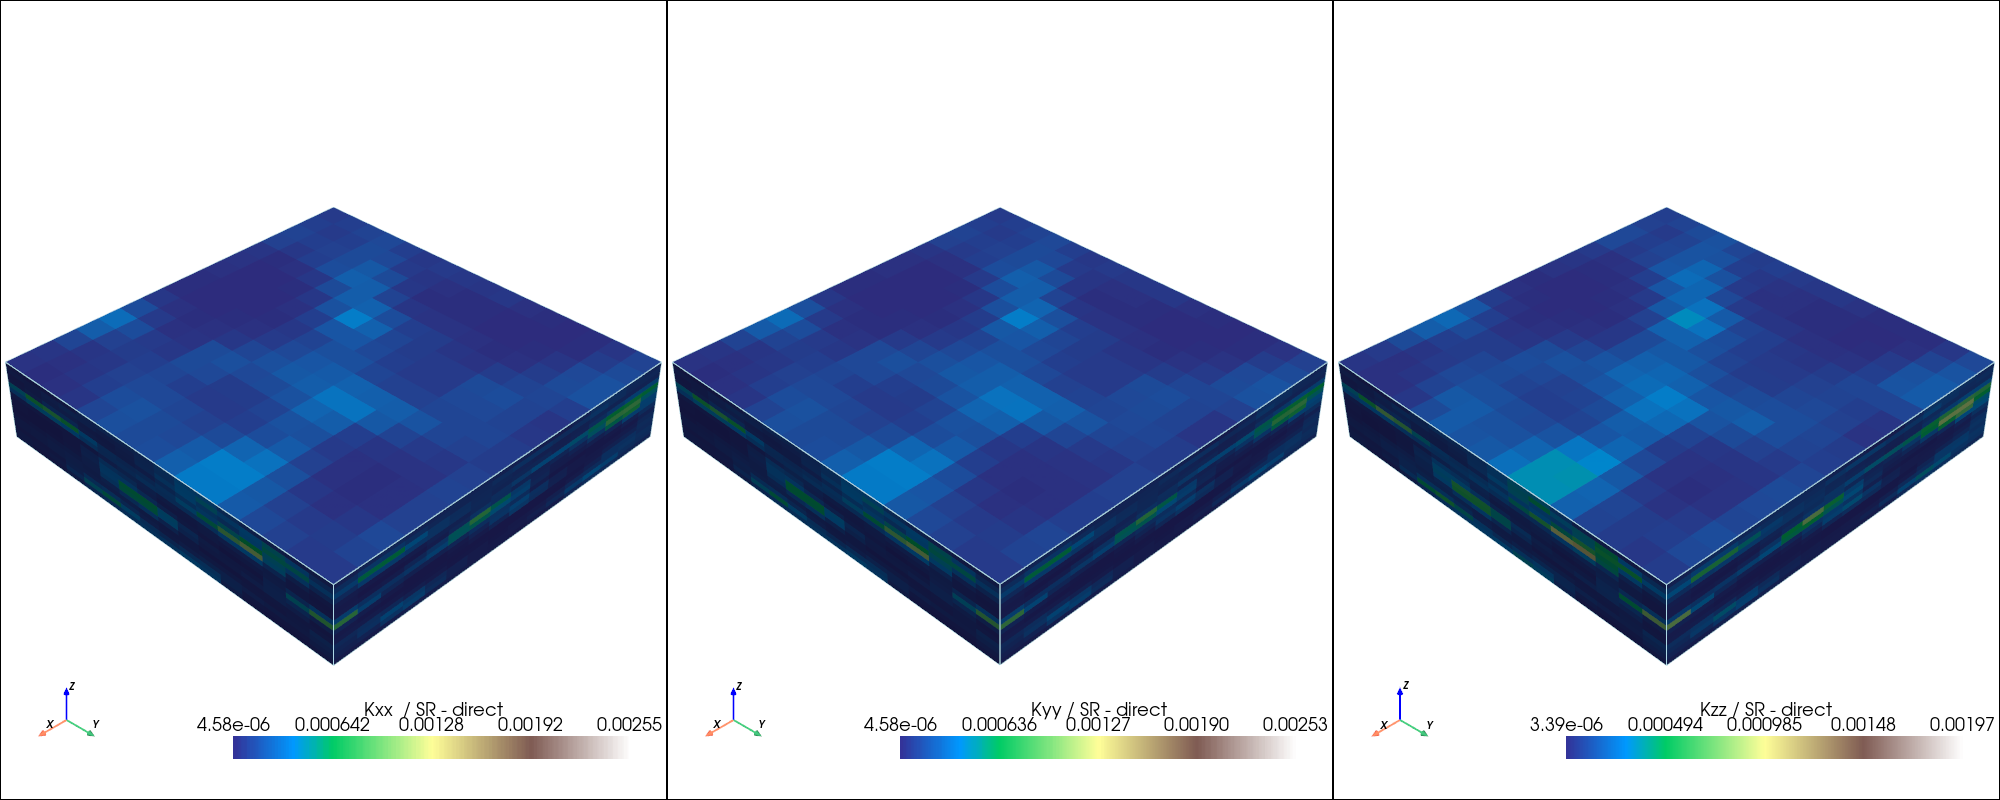

In [6]:
pl = pv.Plotter(shape=(1, 3), window_size=[2000, 800])
arr = field_kxx
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kxx  / SR - direct"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 1)
arr = field_kyy
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kyy / SR - direct"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 2)
arr = field_kzz
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kzz / SR - direct"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

# pl.add_title("Standard renormalization - direct", font='times', color='k', font_size=40)
pl.show()

### Centered scheme

In [7]:
field_kxx, field_kyy, field_kzz = upscale_k(sim.val[0], method="standard_renormalization", dx=2, dy=2, dz=.4, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z, scheme="center")

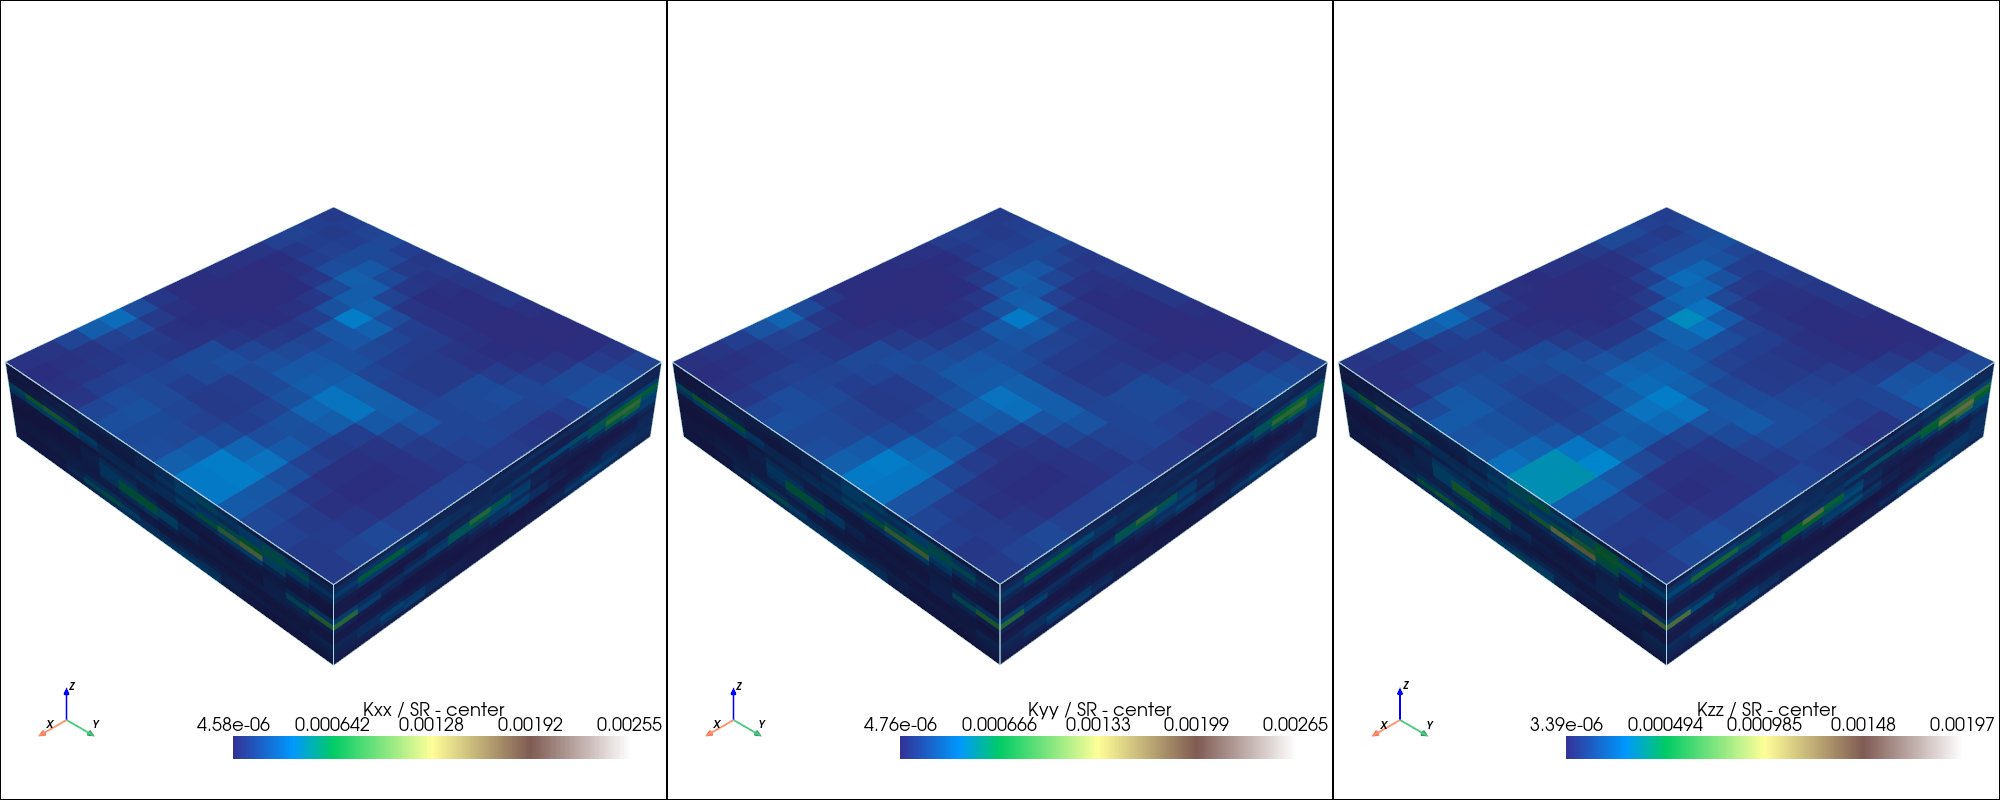

In [8]:
pl = pv.Plotter(shape=(1, 3), window_size=[2000, 800])
arr = field_kxx
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kxx / SR - center"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 1)
arr = field_kyy
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kyy / SR - center"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 2)
arr = field_kzz
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kzz / SR - center"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.show()

## Tensorial renormalization

In [9]:
field_kxx, field_kyy, field_kzz = upscale_k(sim.val[0], method="tensorial_renormalization", dx=2, dy=2, dz=.4, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z)

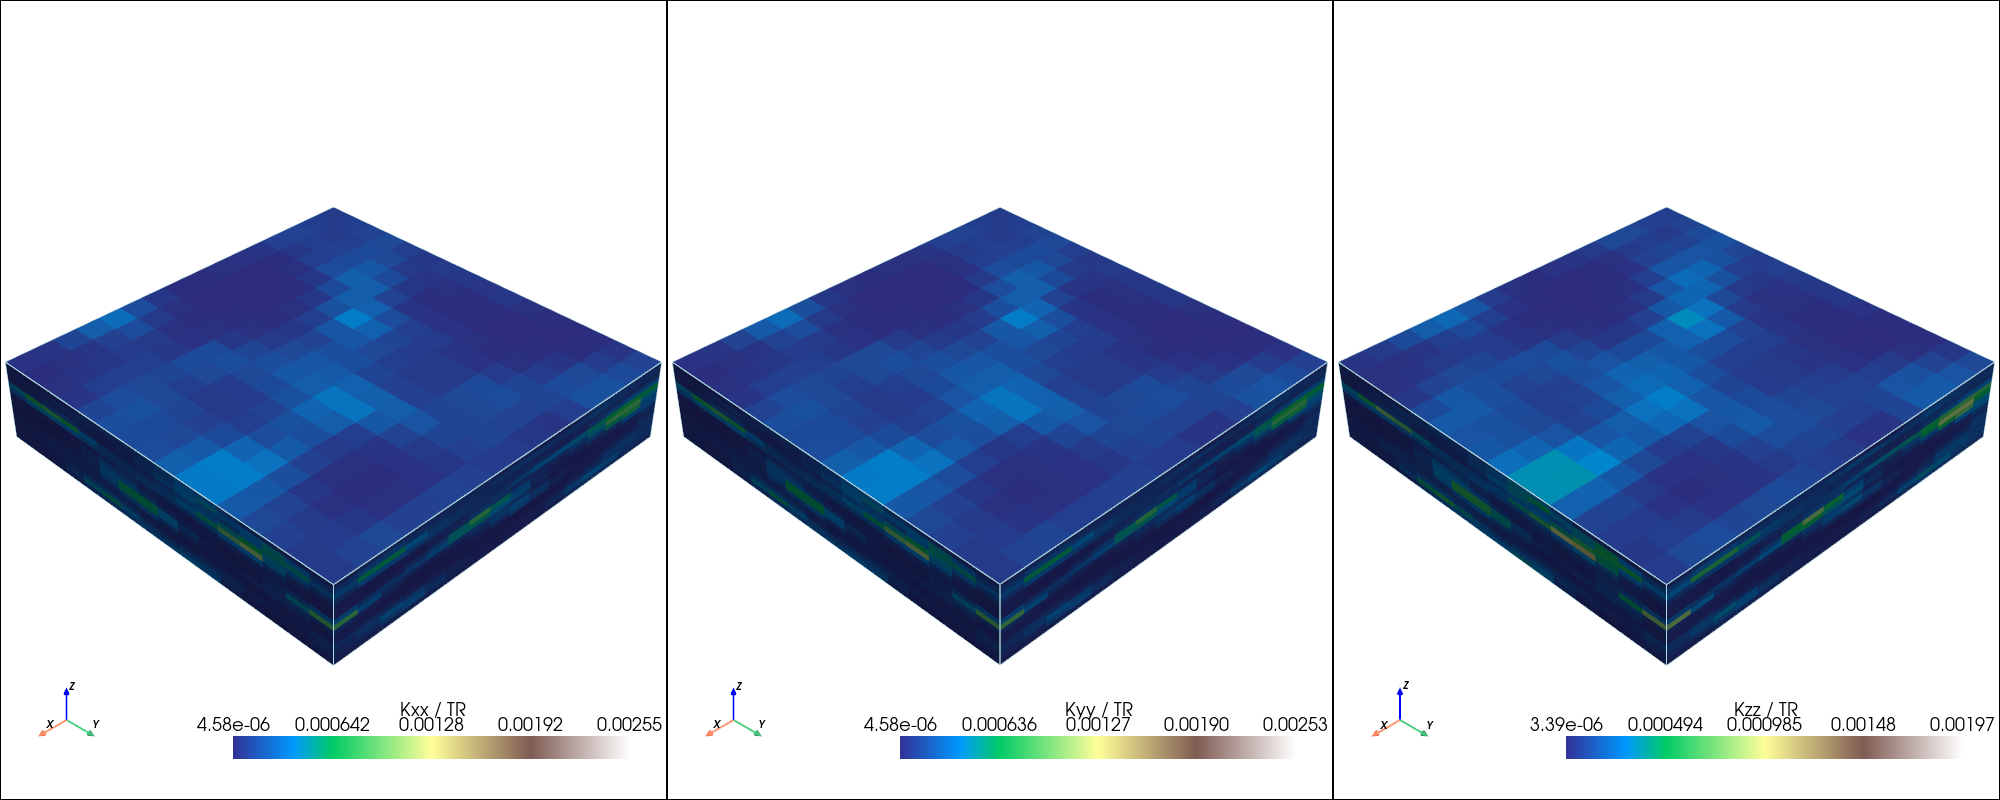

In [10]:
pl = pv.Plotter(shape=(1, 3), window_size=[2000, 800])
arr = field_kxx
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kxx / TR"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 1)
arr = field_kyy
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kyy / TR"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 2)
arr = field_kzz
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kzz / TR"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.show()

## Simplified renormalization

In [11]:
field_kxx, field_kyy, field_kzz = upscale_k(sim.val[0], method="simplified_renormalization", dx=2, dy=2, dz=.4, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z)

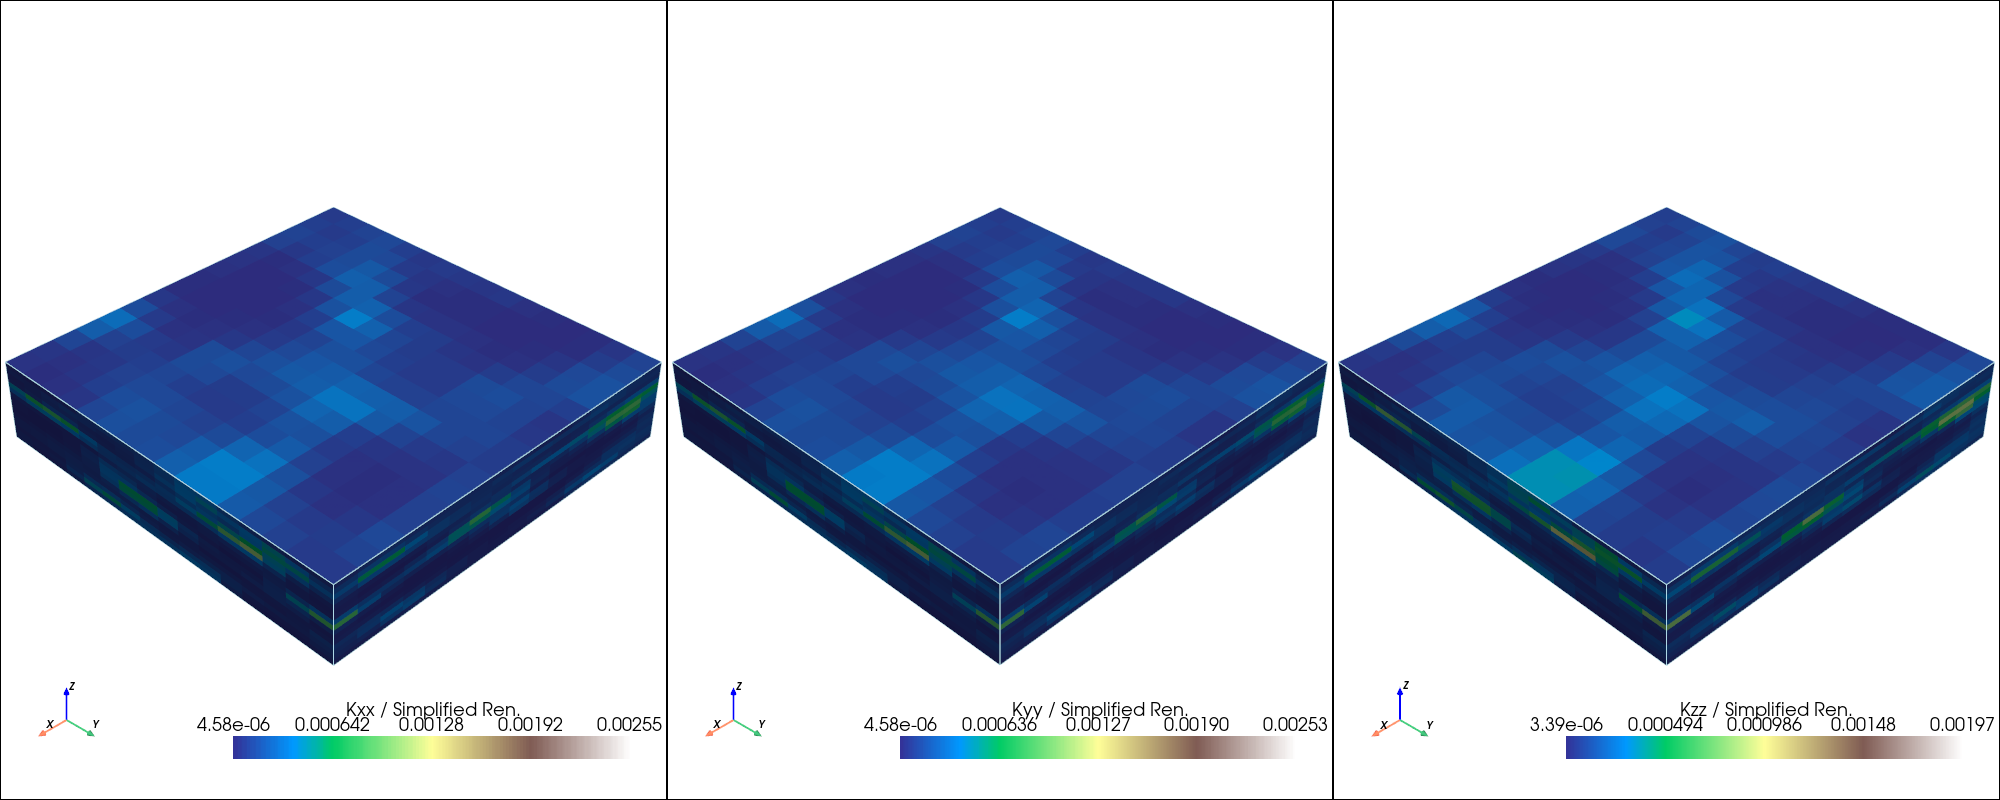

In [12]:
pl = pv.Plotter(shape=(1, 3), window_size=[2000, 800])
arr = field_kxx
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kxx / Simplified Ren."])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 1)
arr = field_kyy
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kyy / Simplified Ren."])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 2)
arr = field_kzz
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Kzz / Simplified Ren."])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.show()

In [13]:
field_ari = upscale_k(sim.val[0], method="arithmetic", dx=2, dy=2, dz=.4, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z)
field_har = upscale_k(sim.val[0], method="harmonic", dx=2, dy=2, dz=.4, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z)
field_geo = upscale_k(sim.val[0], method="geometric", dx=2, dy=2, dz=.4, factor_x=factor_x, factor_y=factor_y, factor_z=factor_z)

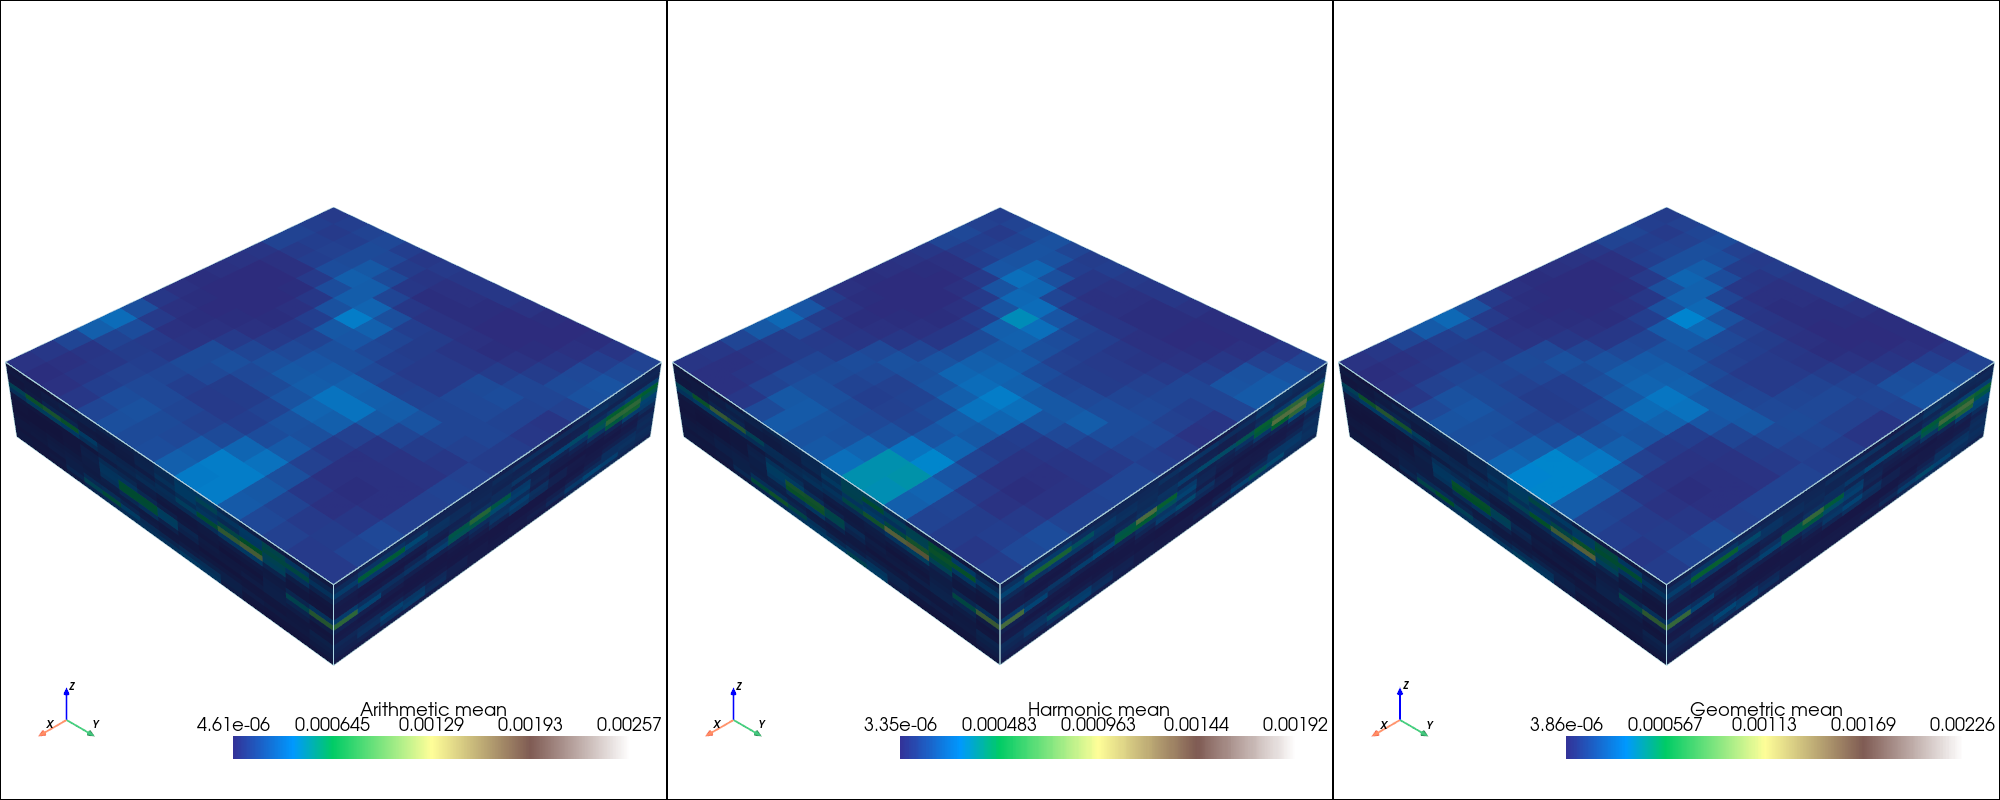

In [14]:
pl = pv.Plotter(shape=(1, 3), window_size=[2000, 800])
arr = field_ari
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Arithmetic mean"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 1)
arr = field_har
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Harmonic mean"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.subplot(0, 2)
arr = field_geo
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=2*factor_x, sy=2*factor_y, sz=0.4*factor_z, nv=1, val=arr.reshape(1, *arr.shape), varname=["Geometric mean"])
geone.imgplot3d.drawImage3D_surface(im, cmap="terrain", plotter=pl)

pl.show()